# Setup

In [1]:
# Odkomentować, aby pobrać pakiet
# %pip install numpy
# %pip install pandas
# %pip install scikit-learn
# %pip install seaborn
# %pip install matplotlib
# %pip install tensorflow
# %pip install tensorflow_datasets

## Importy

In [2]:
import sys

import numpy as np
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display

2024-06-14 20:31:30.153175: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 20:31:30.995079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Wersje pythona i tensorflow'a:

In [3]:
print("Python: ", sys.version)
print("tensorflow: ", tf.__version__)

Python:  3.11.9 (main, May 24 2024, 03:01:36) [GCC 14.1.1 20240507]
tensorflow:  2.16.1


## Załadowanie dataset'u

https://www.tensorflow.org/datasets/catalog/speech_commands

In [4]:
datasets, info = tfds.load("speech_commands", 
                           split=["train", "validation", "test"],
                           with_info=True,
                           as_supervised=True)
train_ds, val_ds, test_ds = datasets

2024-06-14 20:31:31.864491: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 20:31:31.892973: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 20:31:31.893191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Poprawki do danych

In [5]:
def fixup(audio, label):
    # zmiana typu z int na float
    audio = audio / np.iinfo(np.int16).max

    # wyrównanie klipu do jednej sekundy (w próbkowaniu 16kHz)
    audio_frames = tf.shape(audio)[0]
    desired_frames = 16000
    if desired_frames > audio_frames:
        padding = [[0, desired_frames - audio_frames]]
        audio = tf.pad(audio, padding)
    else:
        audio = audio[:desired_frames]
    return audio, label

# zaaplikowanie poprawek do datasetów
train_ds = train_ds.map(fixup)
val_ds = val_ds.map(fixup)
test_ds = test_ds.map(fixup)

# Dane

## Klasy

In [6]:
label_names = info.features["label"].names
print(*label_names, sep="\n", end="\n\n")
print("liczba klas:", info.features["label"].num_classes)

down
go
left
no
off
on
right
stop
up
yes
_silence_
_unknown_

liczba klas: 12


## Rozłożenie klas

2024-06-14 20:31:50.443471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 20:31:52.638303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 20:31:53.720418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


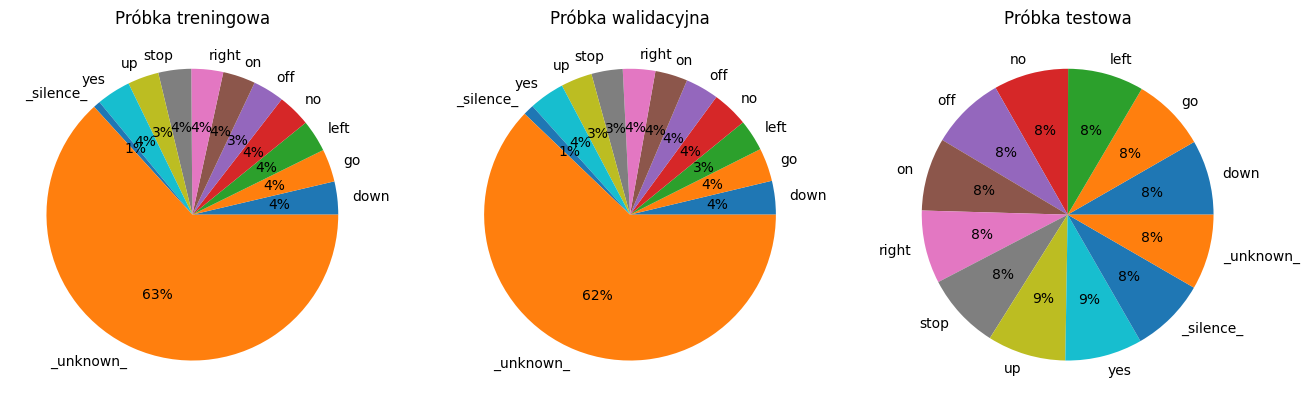

In [7]:
train_labels = [y.numpy() for X, y in train_ds]
val_labels = [y.numpy() for X, y in val_ds]
test_labels = [y.numpy() for X, y in test_ds]

fig, axs = plt.subplots(1, 3, figsize=(16, 10))

unique, counts = np.unique(train_labels, return_counts=True)
unique = [label_names[y] for y in unique]
axs[0].pie(counts, labels=unique, autopct="%.0f%%")
axs[0].set_title("Próbka treningowa")

unique, counts = np.unique(val_labels, return_counts=True)
unique = [label_names[y] for y in unique]
axs[1].pie(counts, labels=unique, autopct="%.0f%%")
axs[1].set_title("Próbka walidacyjna")

unique, counts = np.unique(test_labels, return_counts=True)
unique = [label_names[y] for y in unique]
axs[2].pie(counts, labels=unique, autopct="%.0f%%")
axs[2].set_title("Próbka testowa")

plt.show()

Stosunek klas w próbce testowej i walidacyjnej jest taki sam ze znaczną przewagą \_unknown\_. Próbka testowa posiada wszystkie klasy w tej samej proporcji.

## Przykładowe dane - audio

In [8]:
tfds.as_dataframe(train_ds.take(9), info)

2024-06-14 20:31:54.153151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


audio  label
0  [-0.00045777764, -0.00054933317, -0.0003662221...      4
1  [0.0022888882, 0.0008850368, -0.0025940733, 0....      5
2  [0.0, 0.0, 6.103702e-05, 3.051851e-05, 6.10370...      7
3  [3.051851e-05, 0.00045777764, 0.00039674062, 0...      5
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      7
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      2
6  [0.0013733329, 0.0025025178, 0.0012207404, 0.0...     11
7  [0.0008850368, 0.0026551103, 0.004608295, 0.00...      7
8  [-0.0003662221, -0.00045777764, -0.0006103702,...      6

## Przykładowe dane - wykresy

2024-06-14 20:31:54.585869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


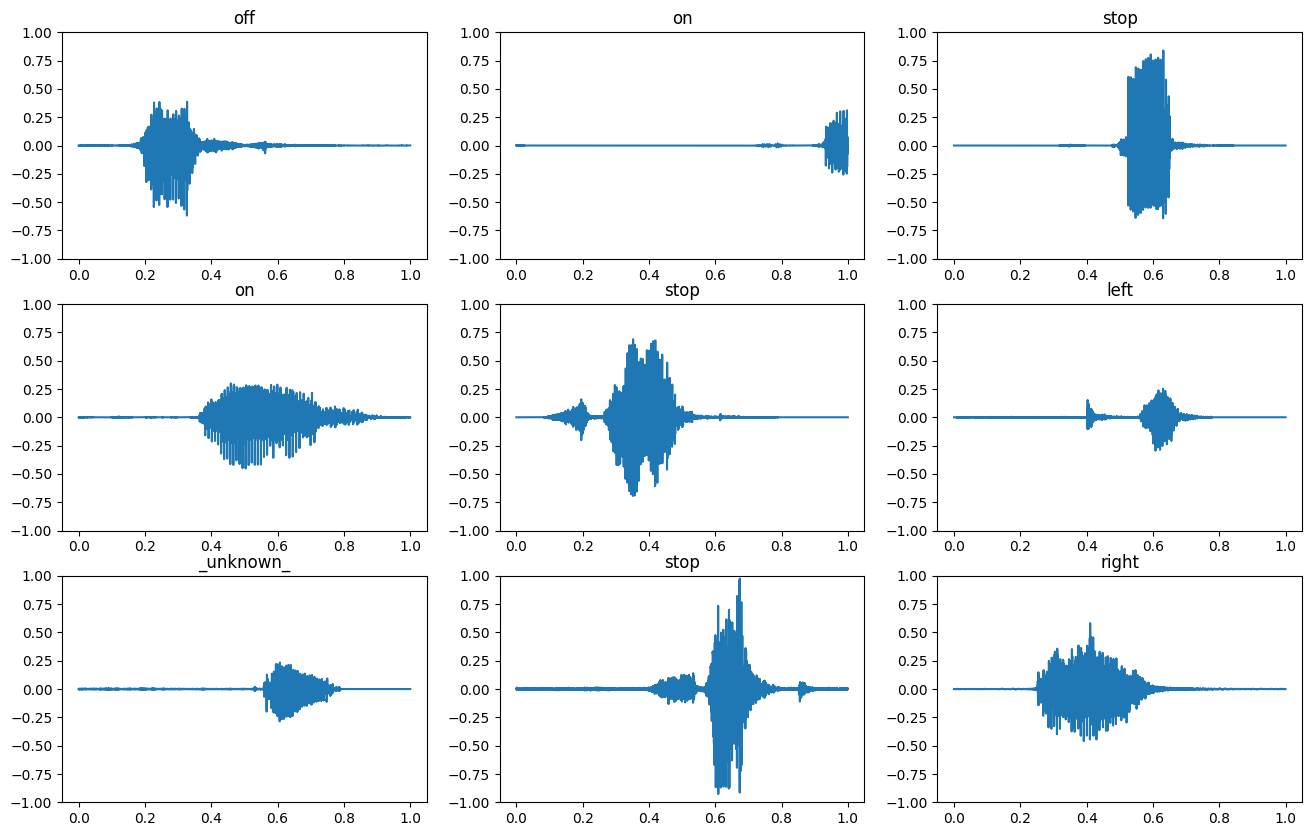

In [9]:
rows = 3
cols = 3
n = rows * cols
fig, axs = plt.subplots(rows, cols, figsize=(16, 10))
for k, (audio, label) in enumerate(train_ds.take(n)):
    i, j = divmod(k, cols)
    ts = np.linspace(0, 1, 16000)
    audio = np.pad(audio, [[0, 16000 - len(audio)]])
    axs[i, j].plot(ts, audio)
    axs[i, j].set_title(info.features["label"].names[label])
    axs[i, j].set_ylim(-1, 1)
plt.show()

# Preprocessing

## Spektrogram w skali Mela

In [10]:
fft_length=256
sequence_stride=128
sequence_length=None
window='hann'
sampling_rate=16000
num_mel_bins=64
min_freq=20.0
max_freq=None
power_to_db=True
top_db=80.0
mag_exp=2.0
min_power=1e-10
ref_power=1.0

mel_spectrogram_layer = layers.MelSpectrogram(
    fft_length=fft_length,
    sequence_stride=sequence_stride,
    sequence_length=sequence_length,
    window=window,
    sampling_rate=sampling_rate,
    num_mel_bins=num_mel_bins,
    min_freq=min_freq,
    max_freq=max_freq,
    power_to_db=power_to_db,
    top_db=top_db,
    mag_exp=mag_exp,
    min_power=min_power,
    ref_power=ref_power,
    name="mel_spectrogram"
)

def get_spectrogram(audio):
    return tf.transpose(mel_spectrogram_layer(audio))

def draw_spectrogram(ax, spectrogram, **kwargs):
    ax.imshow(tf.transpose(spectrogram), **kwargs)

## Warstwa preprocessingu

In [11]:
preprocessing_layer =  keras.Sequential([
    keras.Input((16000,)),
    mel_spectrogram_layer,
    # permutacja, aby dane miały kształt (time, num_mel_bins)
    layers.Permute((2, 1))
])

## Datasety spektrogramów

In [12]:
batch_size=32

train_spectrogram_ds = (train_ds
                        .batch(batch_size)
                        .map(lambda X, y: (preprocessing_layer(X), y))
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

val_spectrogram_ds = (val_ds
                      .batch(batch_size)
                      .map(lambda X, y: (preprocessing_layer(X), y))
                      .prefetch(buffer_size=tf.data.AUTOTUNE))

test_spectrogram_ds = (test_ds
                       .batch(batch_size)
                       .map(lambda X, y: (preprocessing_layer(X), y))
                       .prefetch(buffer_size=tf.data.AUTOTUNE))

### Przykładowe dane - spektrogramy

2024-06-14 20:31:56.305113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


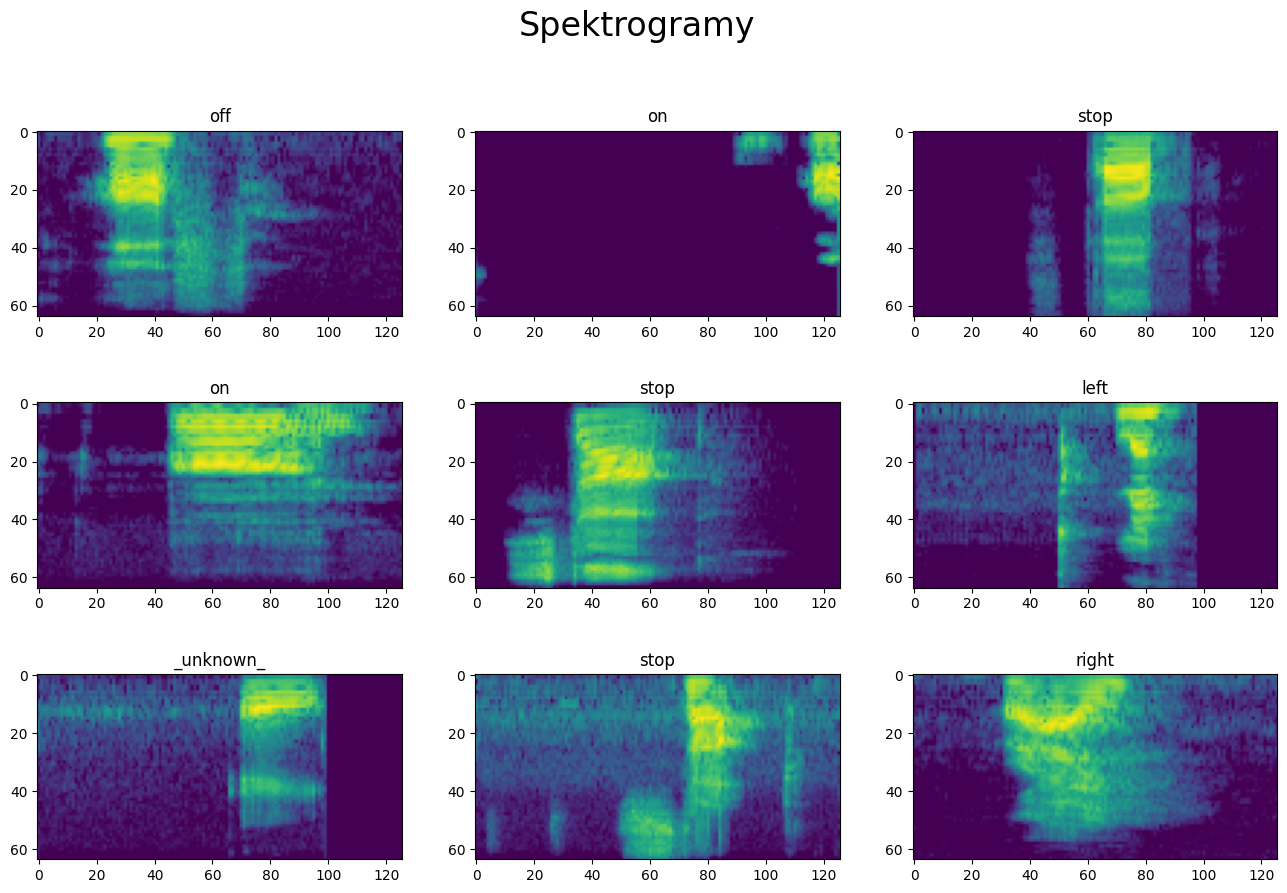

In [13]:
rows = 3
cols = 3
n = rows * cols

rows = 3
cols = 3
n = rows * cols
fig, axs = plt.subplots(rows, cols, figsize=(16, 10))
for Xs, ys in train_spectrogram_ds.take(1):
    for k, (spectrogram, label) in enumerate(zip(Xs[:n], ys[:n])):
            i, j = divmod(k, cols)
            draw_spectrogram(axs[i, j], spectrogram)
            axs[i, j].set_title(label_names[label])
fig.suptitle("Spektrogramy", fontsize=24)
plt.show()

## Normalizacja

In [14]:
normalization_layer = layers.Normalization(name="normalization")
normalization_layer.adapt(
    data=train_spectrogram_ds.map(lambda X, y: X),
)

2024-06-14 20:32:16.029320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Przykładowe dane - znormalizowane spektrogramy

2024-06-14 20:32:16.780555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


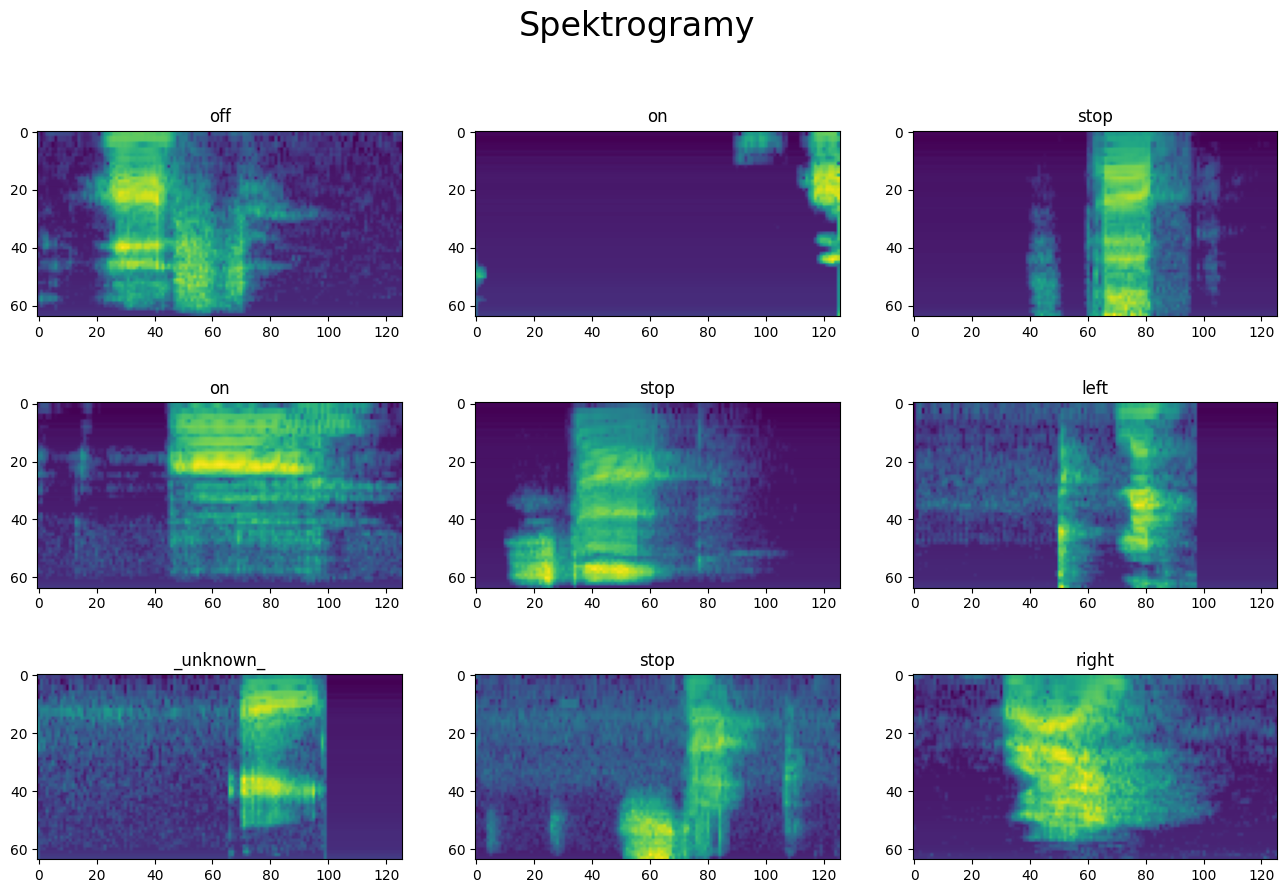

In [15]:
rows = 3
cols = 3
n = rows * cols

fig, axs = plt.subplots(rows, cols, figsize=(16, 10))
for Xs, ys in train_spectrogram_ds.take(1):
    for k, (spectrogram, label) in enumerate(zip(Xs[:n], ys[:n])):
        i, j = divmod(k, cols)
        draw_spectrogram(axs[i, j], normalization_layer(spectrogram)[0])
        axs[i, j].set_title(label_names[label])
fig.suptitle("Spektrogramy", fontsize=24)
plt.show()

# Model

## Przepis modelu

In [16]:
def build_model(input_shape,
                output_dim,
                filters,
                kernel_size,
                strides,
                dense_units,
                name):
    input_spectrogram = keras.Input(input_shape, name="input")
    x = normalization_layer(input_spectrogram)
    x = layers.Reshape((*input_shape, 1), name="reshape")(x)
    for i, (filters_, kernel_size_, strides_) in enumerate(zip(filters, kernel_size, strides, strict=True)):
        x = layers.Conv2D(
            filters=filters_,
            kernel_size=kernel_size_,
            strides=strides_,
            padding="same",
            use_bias=False,
            name=f"conv_{i+1}"
        )(x)
        x = layers.BatchNormalization(name=f"conv_{i+1}_bn")(x)
        x = layers.ReLU(name=f"conv_{i+1}_relu")(x)
    x = layers.MaxPool2D(name="max_pool")(x)
    x = layers.Flatten(name="flatten")(x)
    for i, dense_units_ in enumerate(dense_units):
        x = layers.Dropout(0.5, name=f"droupout_{i+1}")(x)
        x = layers.Dense(dense_units_, name=f"dense_{i+1}")(x)
        x = layers.BatchNormalization(name=f"dense_{i+1}_bn")(x)
        x = layers.ReLU(name=f"dense_{i+1}_relu")(x)
    x = layers.Dropout(0.5, name=f"droupout_{i+2}")(x)
    x = layers.Dense(output_dim, name="output_dense")(x)
    output = layers.Softmax(name="output_dense_softmax")(x)
    model = keras.Model(input_spectrogram, output, name=name)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

## Hiperparametry

In [17]:
filters = [
    32,
    32,
    32,
]

kernel_size = [
    [11, 41],
    [11, 21],
    [11, 21],
]

strides = [
    [2, 2],
    [1, 2],
    [1, 2],
]

dense_units = [
    128,
]

## Budowa modelu

In [18]:
training_model = build_model((16000 // sequence_stride + 1, num_mel_bins),
                             info.features["label"].num_classes,
                             filters,
                             kernel_size,
                             strides,
                             dense_units,
                             name="training_model")
training_model.summary()

Model: "training_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 126, 64)        │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 126, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 63, 32, 32)     │        14,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_bn (BatchNormalization)  │ (None, 63, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_relu (ReLU)              │ (None, 63, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 63, 16, 32)     │       236,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_bn (BatchNormalization)  │ (None, 63, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_relu (ReLU)              │ (None, 63, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 63, 8, 32)      │       236,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_bn (BatchNormalization)  │ (None, 63, 8, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_relu (ReLU)              │ (None, 63, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool (MaxPooling2D)         │ (None, 31, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ droupout_1 (Dropout)            │ (None, 3968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       508,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_bn (BatchNormalization) │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_relu (ReLU)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ droupout_2 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 12)             │         1,548 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_softmax (Softmax)  │ (None, 12)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 998,125 (3.81 MB)

 Trainable params: 997,548 (3.81 MB)

 Non-trainable params: 577 (2.26 KB)

## Callbacki

In [19]:
early_stopping = keras.callbacks.EarlyStopping(
    start_from_epoch=30
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="training_model.keras",
    save_best_only=True
)

csv_logger = keras.callbacks.CSVLogger("history.log")

reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau()

callbacks = [
    early_stopping,
    model_checkpoint,
    csv_logger,
    reduce_lr_on_plateau
]

## Trening

In [20]:
epochs = 100

history = training_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1718389940.197828   40002 service.cc:145] XLA service 0x7af388ac29c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718389940.197873   40002 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-06-14 20:32:20.288286: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-14 20:32:20.518787: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   7/2673 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.2295 - loss: 2.5297 

I0000 00:00:1718389945.998075   40002 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2673/2673 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - accuracy: 0.6819 - loss: 1.1272 - val_accuracy: 0.8729 - val_loss: 0.3949 - learning_rate: 0.0010
Epoch 2/100
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.8855 - loss: 0.3658 - val_accuracy: 0.9274 - val_loss: 0.2492 - learning_rate: 0.0010
Epoch 3/100
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.9178 - loss: 0.2626 - val_accuracy: 0.9152 - val_loss: 0.2534 - learning_rate: 0.0010
Epoch 4/100
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - accuracy: 0.9345 - loss: 0.2137 - val_accuracy: 0.9383 - val_loss: 0.1890 - learning_rate: 0.0010
Epoch 5/100
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.9435 - loss: 0.1812 - val_accuracy: 0.9483 - val_loss: 0.1720 - learning_rate: 0.0010
Epoch 6/100
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0.9515 - loss: 0.1571 - val_accuracy: 0.9562 - val_loss: 0.1533 - learning_rate: 0.0010
Epoch 7/100
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - accuracy: 0

# Ewaluacja

## Przebieg uczenia

In [21]:
try:
    history_df = pd.DataFrame(history.history)
except NameError:
    history_df = pd.read_csv("history.log")

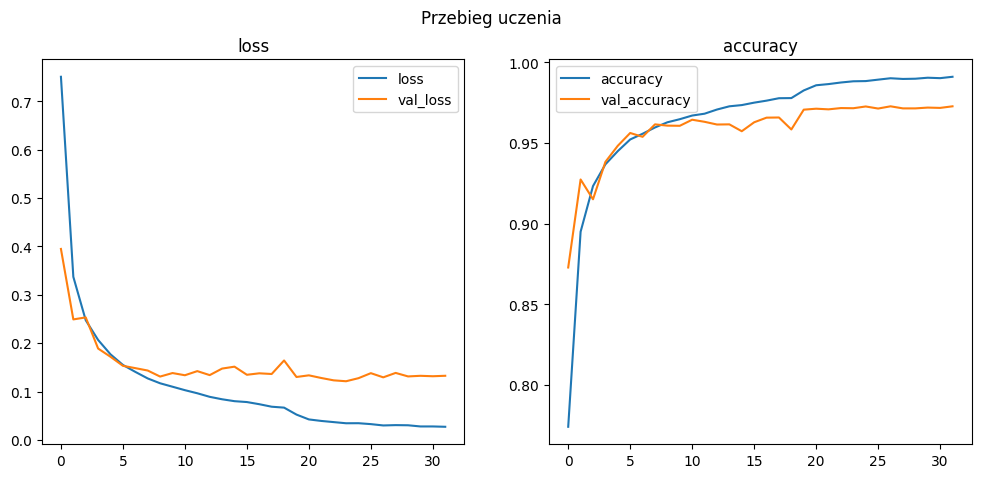

In [22]:
accuracy_df = history_df[["accuracy", "val_accuracy"]]
loss_df = history_df[["loss", "val_loss"]]
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Przebieg uczenia")
loss_df.plot(ax=axs[0], title="loss")
accuracy_df.plot(ax=axs[1], title="accuracy")
plt.show()

### Precision i recall

In [23]:
y_train_true = list(train_spectrogram_ds.map(lambda X, y: y).unbatch())
y_train_pred = training_model.predict(train_spectrogram_ds)
y_train_pred = np.argmax(y_train_pred, axis=-1)
y_val_true = list(val_spectrogram_ds.map(lambda X, y: y).unbatch())
y_val_pred = training_model.predict(val_spectrogram_ds)
y_val_pred = np.argmax(y_val_pred, axis=-1)

print("Train precision:", metrics.precision_score(y_train_true, y_train_pred, average='macro'))
print("Train recall:", metrics.recall_score(y_train_true, y_train_pred, average='macro'))

print("Validation precision:", metrics.precision_score(y_val_true, y_val_pred, average='macro'))
print("Validation recall:", metrics.recall_score(y_val_true, y_val_pred, average='macro'))

2024-06-14 21:00:45.129601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2673/2673 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step
  1/316 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step

2024-06-14 21:01:06.633007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Train precision: 0.997574908387747
Train recall: 0.9914432295200477
Validation precision: 0.9565195852206753
Validation recall: 0.9500564574741149


## Wynik na zbiorze testowym

In [24]:
loss, acc = training_model.evaluate(test_spectrogram_ds)

print("Accuracy:", acc)
print("Loss:", loss)

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9500 - loss: 0.2434
Accuracy: 0.9492842555046082
Loss: 0.2624077796936035


### Precision i recall

In [25]:
y_true = list(test_spectrogram_ds.map(lambda X, y: y).unbatch())
y_pred = training_model.predict(test_spectrogram_ds)
y_pred = np.argmax(y_pred, axis=-1)

print("Precision: ", metrics.precision_score(y_true, y_pred, average='macro'))
print("Recall: ", metrics.recall_score(y_true, y_pred, average='macro'))

  8/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step   

2024-06-14 21:01:11.923303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Precision:  0.960236847285603
Recall:  0.949107245860343


### Confusion Matrix

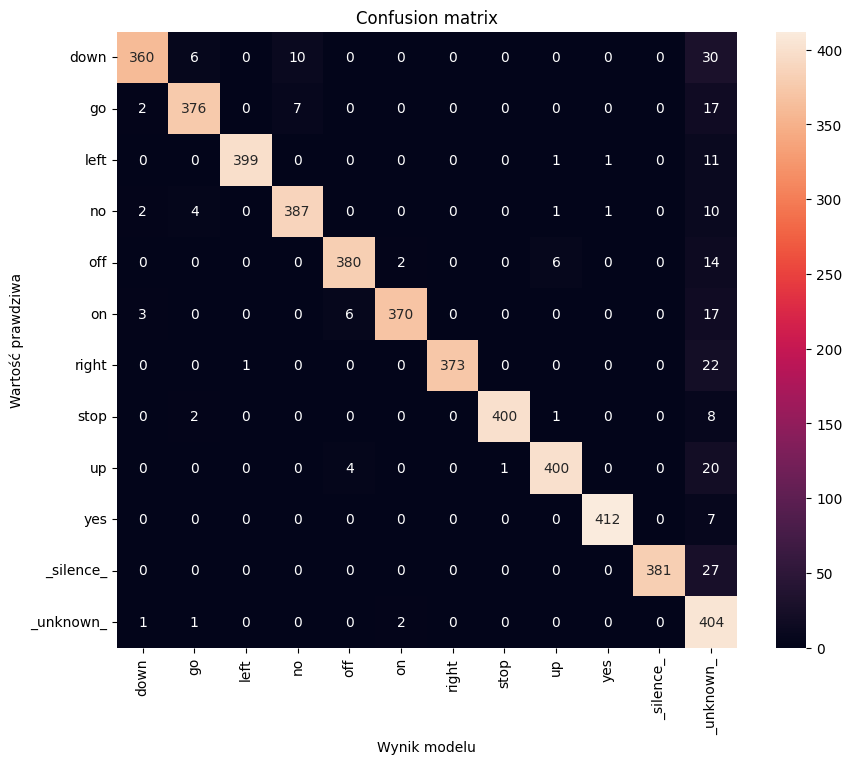

In [26]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix,
            xticklabels=label_names,
            yticklabels=label_names,
            fmt=".3g",
            annot=True)
plt.xlabel("Wynik modelu")
plt.ylabel("Wartość prawdziwa")
plt.title("Confusion matrix")
plt.show()

# Model inferencyjny

In [28]:
inference_model = keras.Sequential([
    keras.Input((16000,)),
    preprocessing_layer,
    training_model
])

inference_model.save("inference_model.keras")